<a href="https://colab.research.google.com/github/cityu-assignment/CS3481-assignment3/blob/main/cs3481_asm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

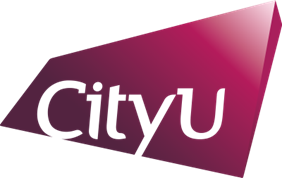

# **CS3481 Fundamentals of Data Science**

**Student Name: Lee Chak Kei**

**Student ID: 56682401**

# Import library

Importing necessary libraries then checks if the code is running in Google Colab and installs dtreeviz package silently, if it is.

In [178]:
import numpy as np 
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans

from matplotlib.pyplot import figure

# Data Processing

The code loads a dataset file column_3C_weka.arff using arff.loadarff() function from scipy.io module, and creates a Pandas DataFrame from the data.

In [179]:
from scipy.io import arff

data = arff.loadarff("/content/column_3C_weka.arff")
df = pd.DataFrame(data[0])
df

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,b'Hernia'
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,b'Hernia'
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,b'Hernia'
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,b'Hernia'
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,b'Hernia'
...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,b'Normal'
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,b'Normal'
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,b'Normal'
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,b'Normal'


The code converts the data type of the 'class' column to string, and removes the first character ('b') of each element of the column (b'Hernia').

In [182]:
df['class'] = df['class'].astype('string')
df['class'] = [i[2:-1] for i in df['class']]
df['class']

0      Hernia
1      Hernia
2      Hernia
3      Hernia
4      Hernia
        ...  
305    Normal
306    Normal
307    Normal
308    Normal
309    Normal
Name: class, Length: 310, dtype: object

In [183]:
columns = df.iloc[:,:6].columns
columns

Index(['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis'],
      dtype='object')

The code selects the first 6 columns of the DataFrame as the feature matrix X.

In [184]:
X = df.iloc[:,:6].values
X

array([[ 63.0278175 ,  22.55258597,  39.60911701,  40.47523153,
         98.67291675,  -0.25439999],
       [ 39.05695098,  10.06099147,  25.01537822,  28.99595951,
        114.4054254 ,   4.56425864],
       [ 68.83202098,  22.21848205,  50.09219357,  46.61353893,
        105.9851355 ,  -3.53031731],
       ...,
       [ 61.44659663,  22.6949683 ,  46.17034732,  38.75162833,
        125.6707246 ,  -2.70787952],
       [ 45.25279209,   8.69315736,  41.5831264 ,  36.55963472,
        118.5458418 ,   0.21475017],
       [ 33.84164075,   5.07399141,  36.64123294,  28.76764934,
        123.9452436 ,  -0.19924909]])

### Normalize the input attributes

In [185]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X

array([[0.35568788, 0.51989984, 0.22917997, 0.2508573 , 0.30746116,
        0.02514839],
       [0.12450104, 0.2967831 , 0.09857833, 0.14462935, 0.47664891,
        0.03636497],
       [0.41166648, 0.51393229, 0.32299466, 0.30766054, 0.38609692,
        0.0175229 ],
       ...,
       [0.34043781, 0.52244298, 0.28789745, 0.23490726, 0.59779618,
        0.01943732],
       [0.18425678, 0.27235174, 0.24684569, 0.21462279, 0.52117504,
        0.02624045],
       [0.07420202, 0.20770855, 0.20261992, 0.14251659, 0.57924032,
        0.02527676]])

### Detect and Remove the Outliers using Z-Score

In [186]:
z_score = np.abs(stats.zscore(X))

threshold = 3
X = X[(z_score < threshold).all(axis=1)]

In [188]:
from sklearn.decomposition import PCA

pca = PCA()
x_pca = pca.fit_transform(X)
x_pca = pd.DataFrame(x_pca)

x_pca['target']=df['class']
x_pca.columns = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'target']
x_pca.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,target
0,0.007358,-0.013808,0.255242,0.025820,-0.037643,1.588691e-12,Hernia
1,-0.349717,-0.002972,0.088084,0.004643,0.028001,-2.698471e-13,Hernia
2,0.098776,-0.017974,0.145838,0.038083,-0.068380,-4.323783e-13,Hernia
3,0.096945,0.005486,0.221022,0.048777,-0.026713,-6.039965e-11,Hernia
4,-0.234453,-0.095885,0.113719,0.067317,0.022692,5.111910e-12,Hernia


## Dimension Reduction PCA

In [191]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([5.94935195e-01, 2.02539161e-01, 1.35824461e-01, 5.08803264e-02,
       1.58208563e-02, 7.59831075e-21])

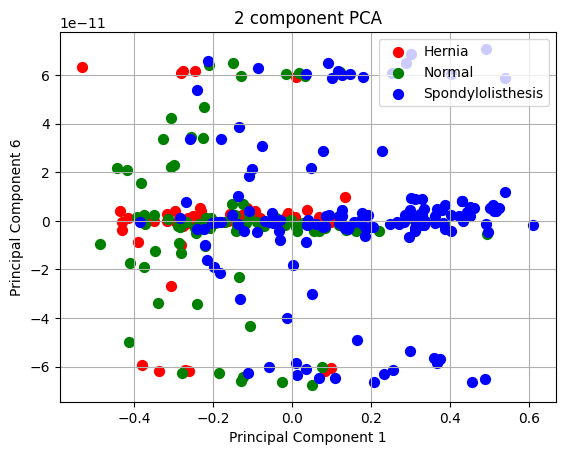

In [192]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1') 
ax.set_ylabel('Principal Component 6') 
ax.set_title('2 component PCA') 
targets = ['Hernia', 'Normal', 'Spondylolisthesis']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
 indicesToKeep = x_pca['target'] == target
 ax.scatter(x_pca.loc[indicesToKeep, 'pelvic_incidence']
 , x_pca.loc[indicesToKeep, 'degree_spondylolisthesis']
 , c = color
 , s = 50)
ax.legend(targets)
ax.grid()

We can say the first and third are the principal components. We only plot the significant features to determin the K value

310 samples with 6 dimensions

In [190]:
print(X.shape)

(298, 6)


In [193]:
all_z = []

# Def Function

In [194]:
# Method: 'single', 'complete', 'average
def constructClustering():
  for i in ['single', 'complete', 'average']:
      Z = linkage(X, i)

      print(i)
      print("="*30)
      print(Z[:200])
      plotClustering(Z)
      plotTruncatedClustering(Z)
      print("="*30)

      all_z.append(Z)

In [195]:
def plotClustering(Z):
  ax = plt.figure(figsize=(25, 10)).subplots()
  dendrogram(Z)
  plt.title('Hierarchical Clustering Dendrogram')
  plt.xlabel('sample index')
  plt.ylabel('distance')
  plt.show()

In [196]:
def plotTruncatedClustering(Z):
  ax = plt.figure(figsize=(25, 10)).subplots()
  
  dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
  )

  plt.title('Hierarchical Clustering Dendrogram (truncated)')
  plt.xlabel('sample index')
  plt.ylabel('distance')
  plt.show()

In [204]:
def extractClustering(K):
  for z in all_z:
    kclusters = fcluster(z, K, criterion='maxclust')

    print("="*30)
    print(kclusters)
    print("="*30)

In [198]:
def constructKmeans(K):
  km = KMeans(n_clusters = K, random_state=0)
  km.fit(X)   
  print(km.labels_)

# Construct Random Forest Models

The function constructRandomForestClassifiers(selected_Criterion) is then defined to analyze multiple random forest model with test 0.3 splits. It uses the RandomForestClassifier function from sklearn.tree to construct a random forest model with a given criterion (entropy or gini) and random state. 

The constructRandomForestClassifiers function is called twice: once with selected_Criterion set to `entropy` and once with selected_Criterion set to `gini`.



## **Compare decision trees**


### **If criterion is entropy**



single
[[2.44000000e+02 2.55000000e+02 2.96270779e-02 2.00000000e+00]
 [2.80000000e+02 2.91000000e+02 3.14367542e-02 2.00000000e+00]
 [5.00000000e+00 2.50000000e+02 3.27745019e-02 2.00000000e+00]
 [1.02000000e+02 2.32000000e+02 3.42514900e-02 2.00000000e+00]
 [2.04000000e+02 2.88000000e+02 4.06840129e-02 2.00000000e+00]
 [1.47000000e+02 2.10000000e+02 4.13206978e-02 2.00000000e+00]
 [2.68000000e+02 2.93000000e+02 4.17795137e-02 2.00000000e+00]
 [2.54000000e+02 2.96000000e+02 4.26346928e-02 2.00000000e+00]
 [2.79000000e+02 3.04000000e+02 4.27842383e-02 3.00000000e+00]
 [5.70000000e+01 2.34000000e+02 4.33255057e-02 2.00000000e+00]
 [3.90000000e+01 5.00000000e+01 4.41133248e-02 2.00000000e+00]
 [2.90000000e+02 2.94000000e+02 4.54635787e-02 2.00000000e+00]
 [7.60000000e+01 1.66000000e+02 4.59181520e-02 2.00000000e+00]
 [4.70000000e+01 5.40000000e+01 4.60767272e-02 2.00000000e+00]
 [2.28000000e+02 2.60000000e+02 4.65841444e-02 2.00000000e+00]
 [2.51000000e+02 2.99000000e+02 4.72965452e-02 3

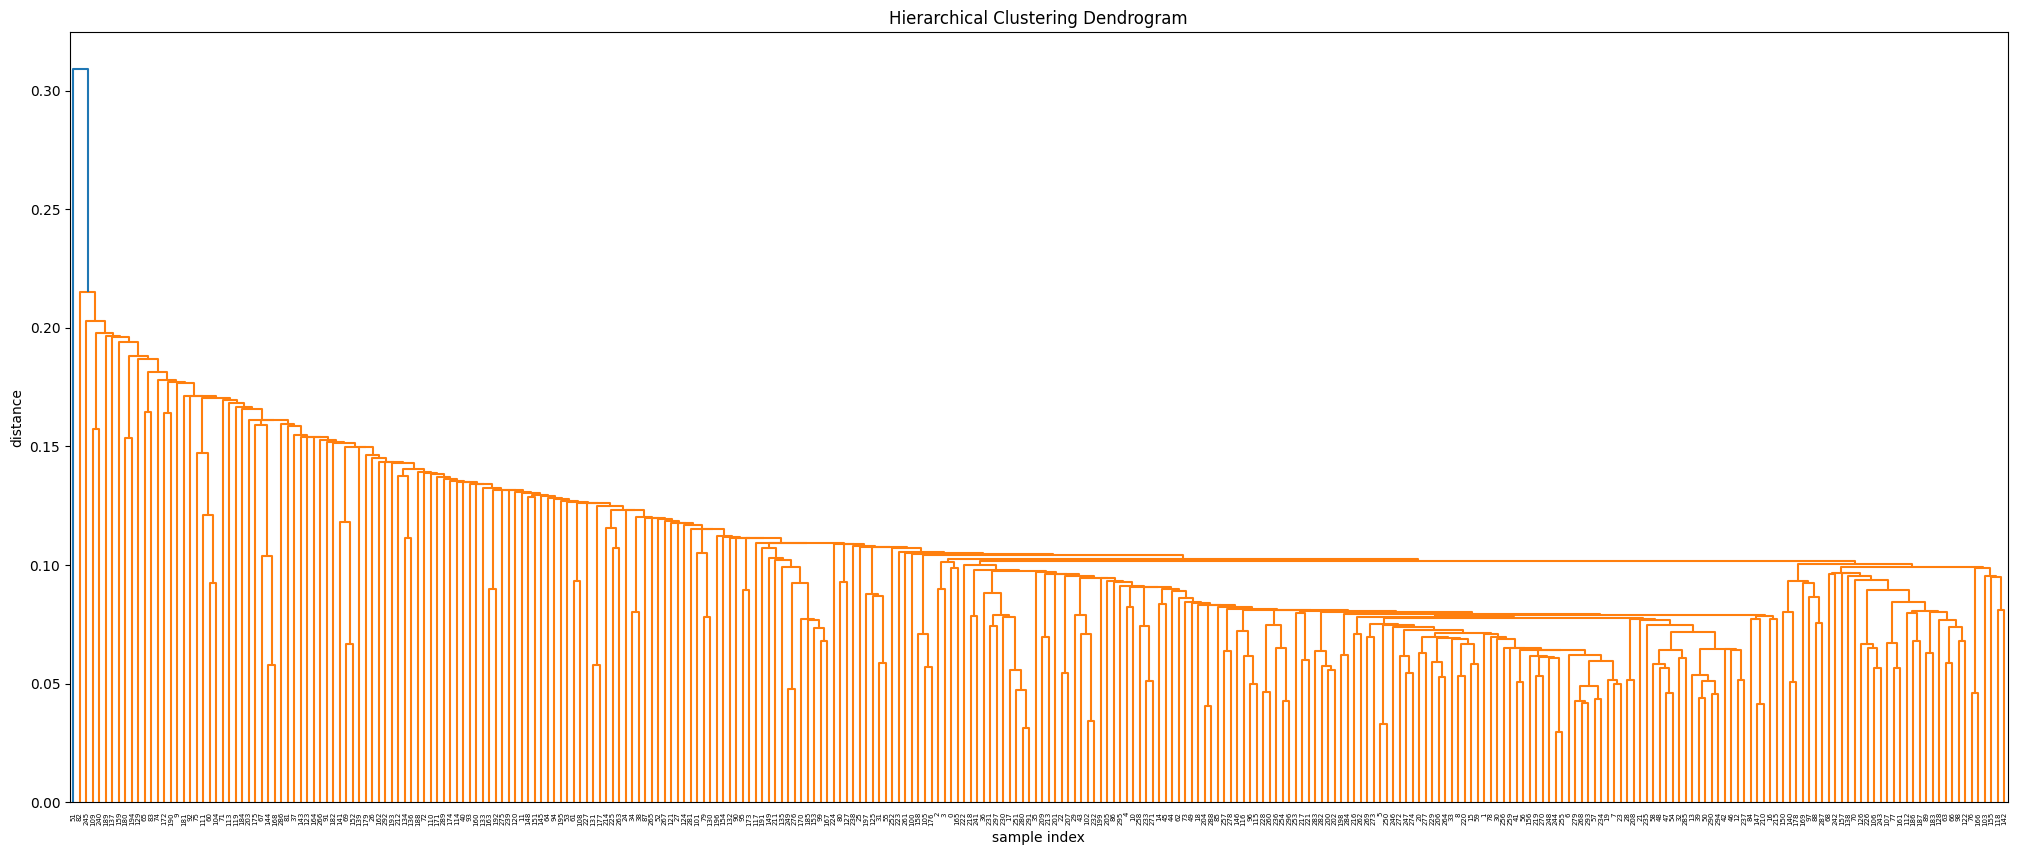

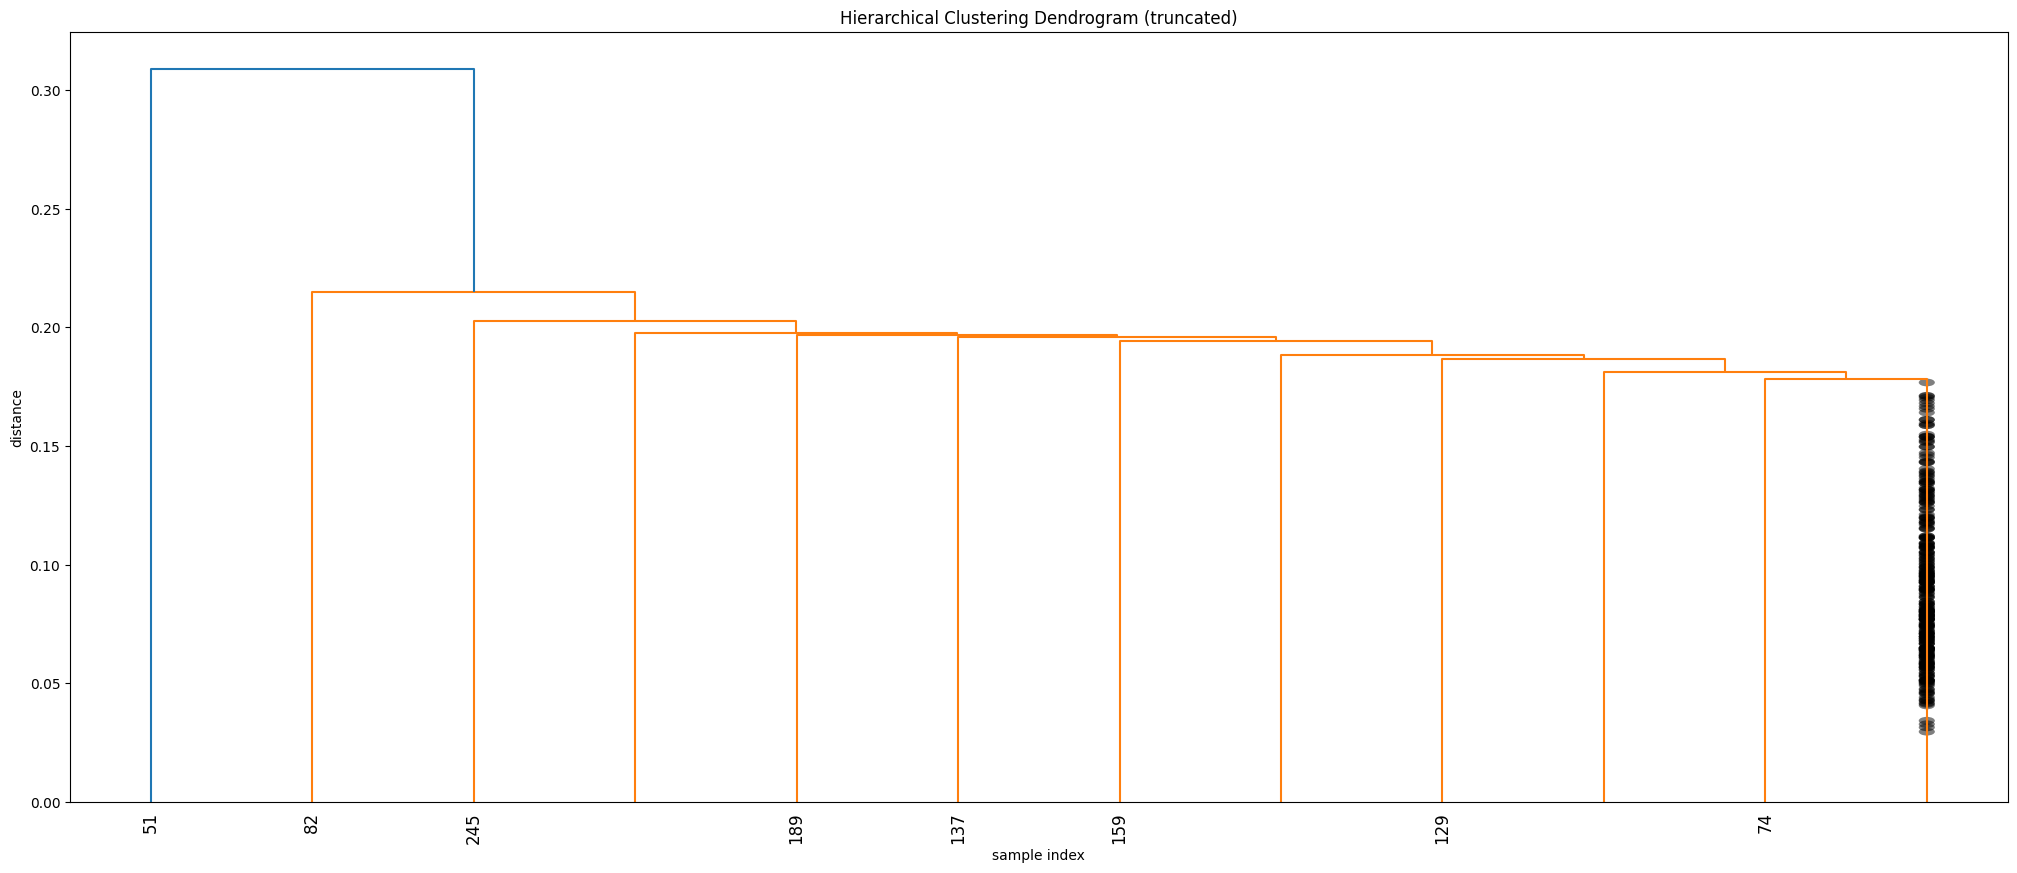

complete
[[2.44000000e+02 2.55000000e+02 2.96270779e-02 2.00000000e+00]
 [2.80000000e+02 2.91000000e+02 3.14367542e-02 2.00000000e+00]
 [5.00000000e+00 2.50000000e+02 3.27745019e-02 2.00000000e+00]
 [1.02000000e+02 2.32000000e+02 3.42514900e-02 2.00000000e+00]
 [2.04000000e+02 2.88000000e+02 4.06840129e-02 2.00000000e+00]
 [1.47000000e+02 2.10000000e+02 4.13206978e-02 2.00000000e+00]
 [2.68000000e+02 2.93000000e+02 4.17795137e-02 2.00000000e+00]
 [2.54000000e+02 2.96000000e+02 4.26346928e-02 2.00000000e+00]
 [5.70000000e+01 2.34000000e+02 4.33255057e-02 2.00000000e+00]
 [3.90000000e+01 5.00000000e+01 4.41133248e-02 2.00000000e+00]
 [2.90000000e+02 2.94000000e+02 4.54635787e-02 2.00000000e+00]
 [7.60000000e+01 1.66000000e+02 4.59181520e-02 2.00000000e+00]
 [4.70000000e+01 5.40000000e+01 4.60767272e-02 2.00000000e+00]
 [2.28000000e+02 2.60000000e+02 4.65841444e-02 2.00000000e+00]
 [2.49000000e+02 2.76000000e+02 4.76721581e-02 2.00000000e+00]
 [7.00000000e+00 2.30000000e+01 4.96399894e-02

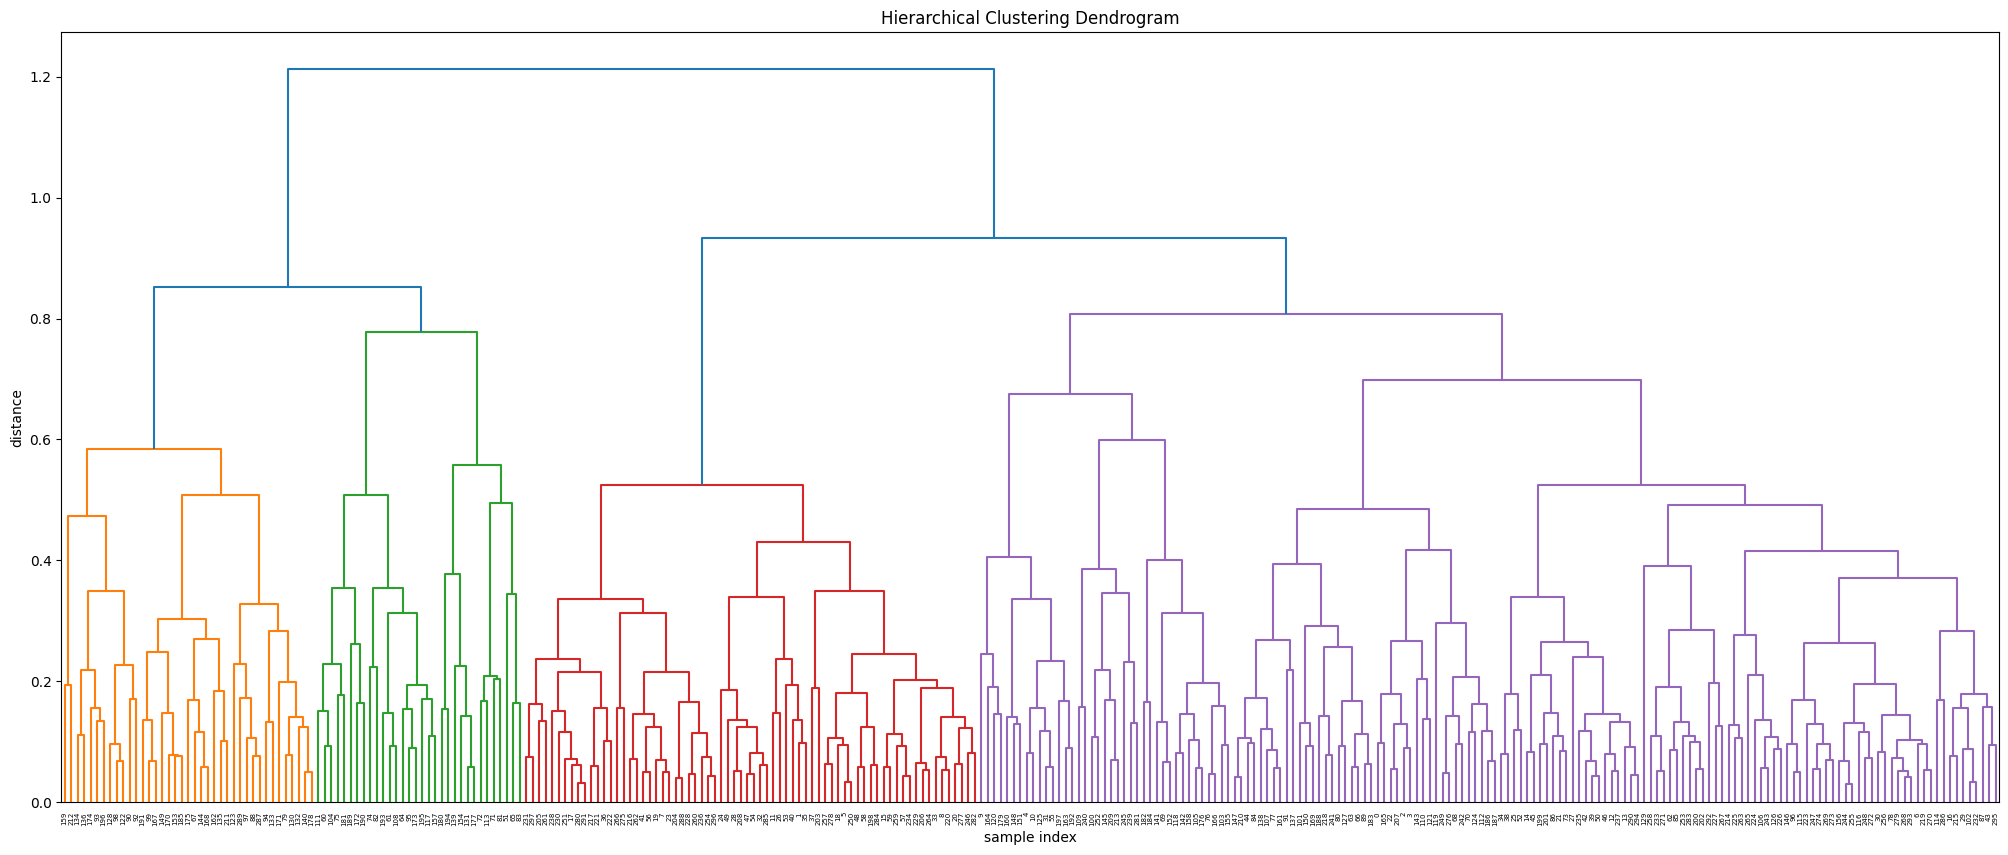

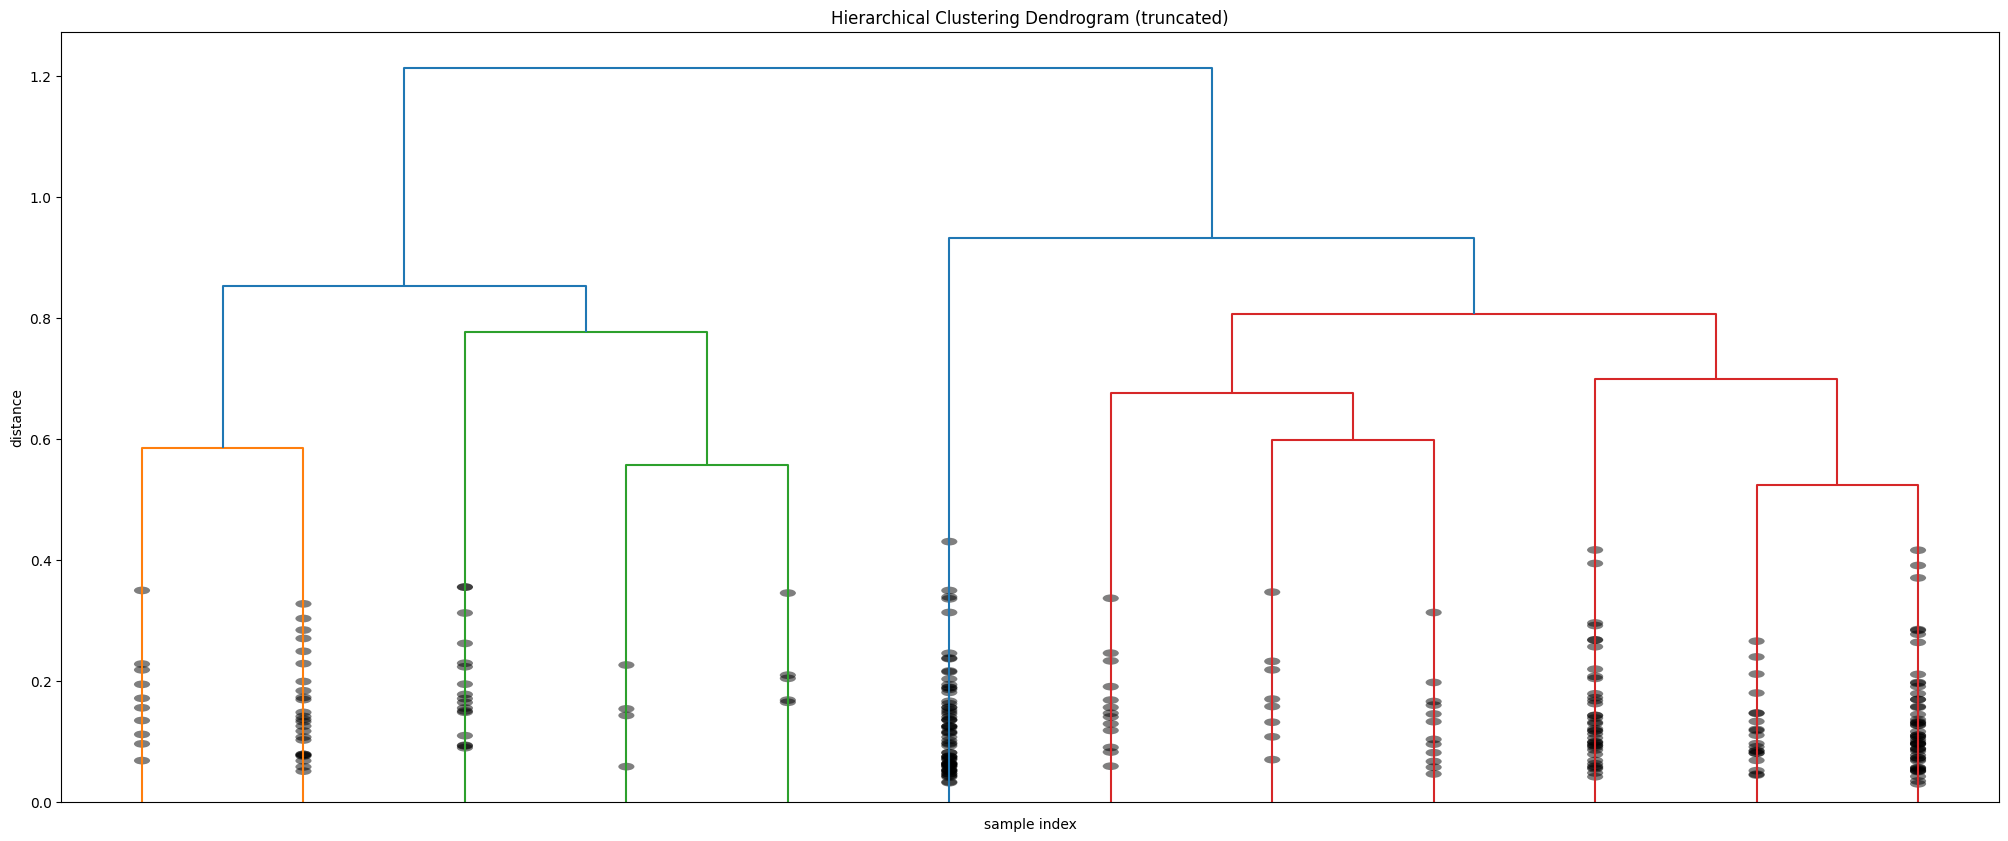

average
[[2.44000000e+02 2.55000000e+02 2.96270779e-02 2.00000000e+00]
 [2.80000000e+02 2.91000000e+02 3.14367542e-02 2.00000000e+00]
 [5.00000000e+00 2.50000000e+02 3.27745019e-02 2.00000000e+00]
 [1.02000000e+02 2.32000000e+02 3.42514900e-02 2.00000000e+00]
 [2.04000000e+02 2.88000000e+02 4.06840129e-02 2.00000000e+00]
 [1.47000000e+02 2.10000000e+02 4.13206978e-02 2.00000000e+00]
 [2.68000000e+02 2.93000000e+02 4.17795137e-02 2.00000000e+00]
 [2.54000000e+02 2.96000000e+02 4.26346928e-02 2.00000000e+00]
 [5.70000000e+01 2.34000000e+02 4.33255057e-02 2.00000000e+00]
 [3.90000000e+01 5.00000000e+01 4.41133248e-02 2.00000000e+00]
 [2.90000000e+02 2.94000000e+02 4.54635787e-02 2.00000000e+00]
 [7.60000000e+01 1.66000000e+02 4.59181520e-02 2.00000000e+00]
 [4.70000000e+01 5.40000000e+01 4.60767272e-02 2.00000000e+00]
 [2.28000000e+02 2.60000000e+02 4.65841444e-02 2.00000000e+00]
 [2.79000000e+02 3.04000000e+02 4.69313084e-02 3.00000000e+00]
 [2.49000000e+02 2.76000000e+02 4.76721581e-02 

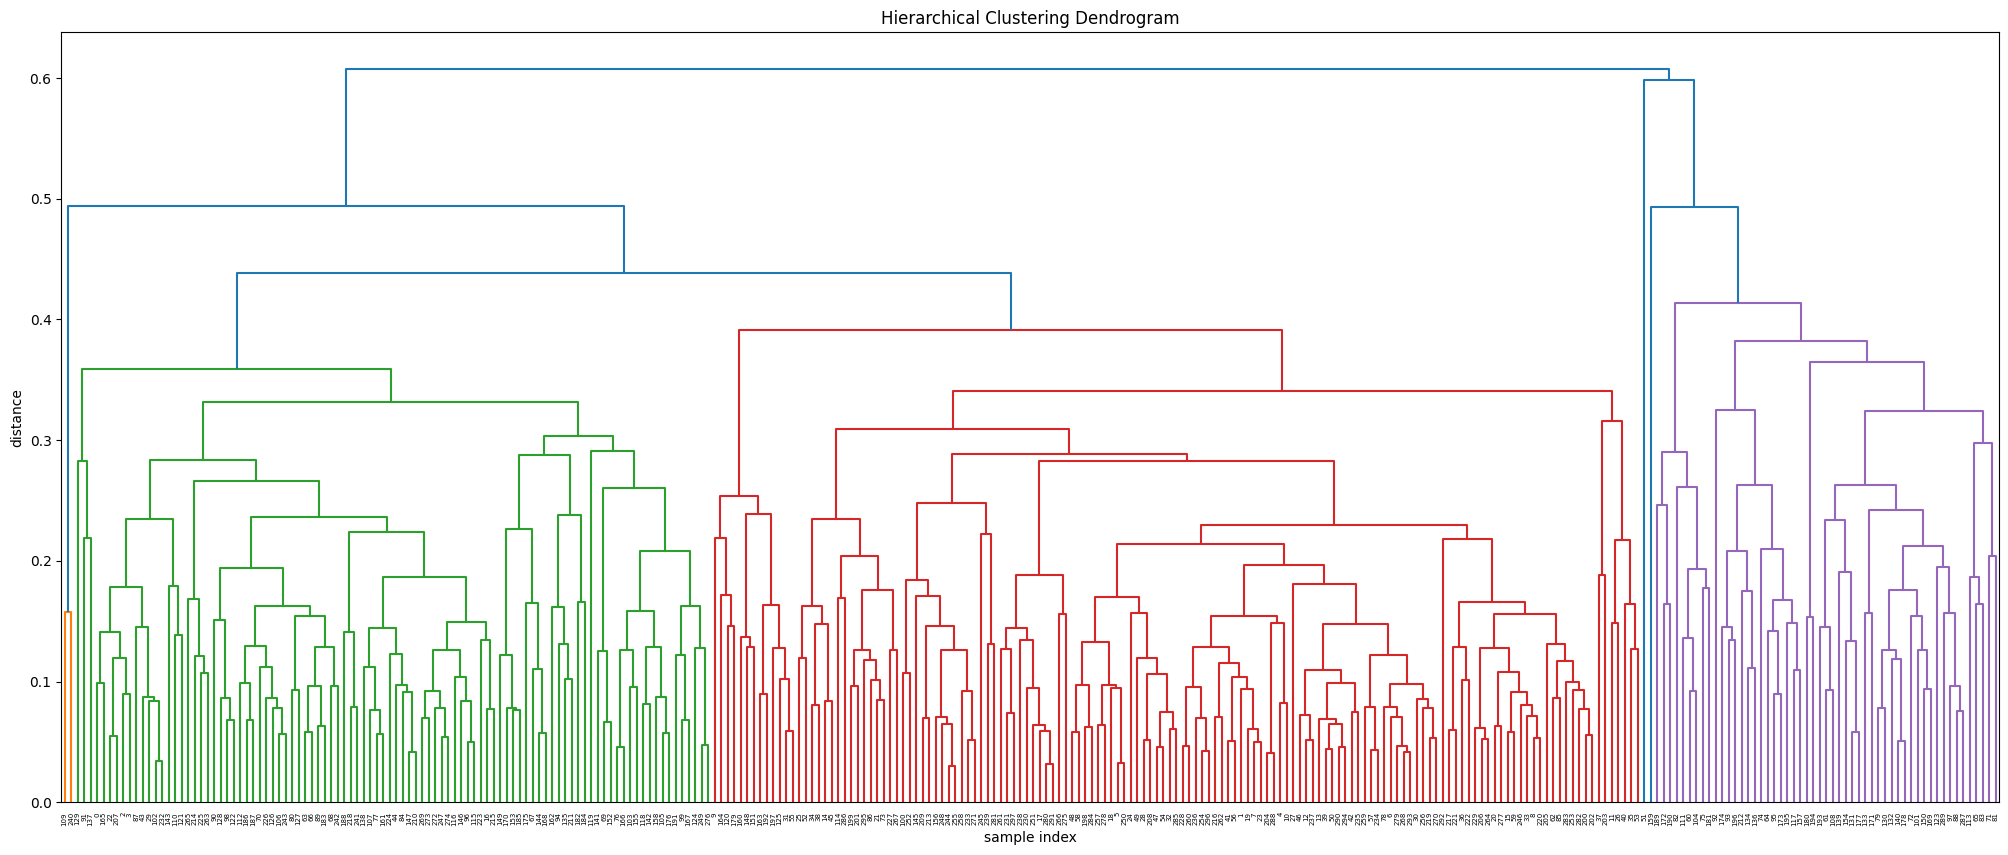

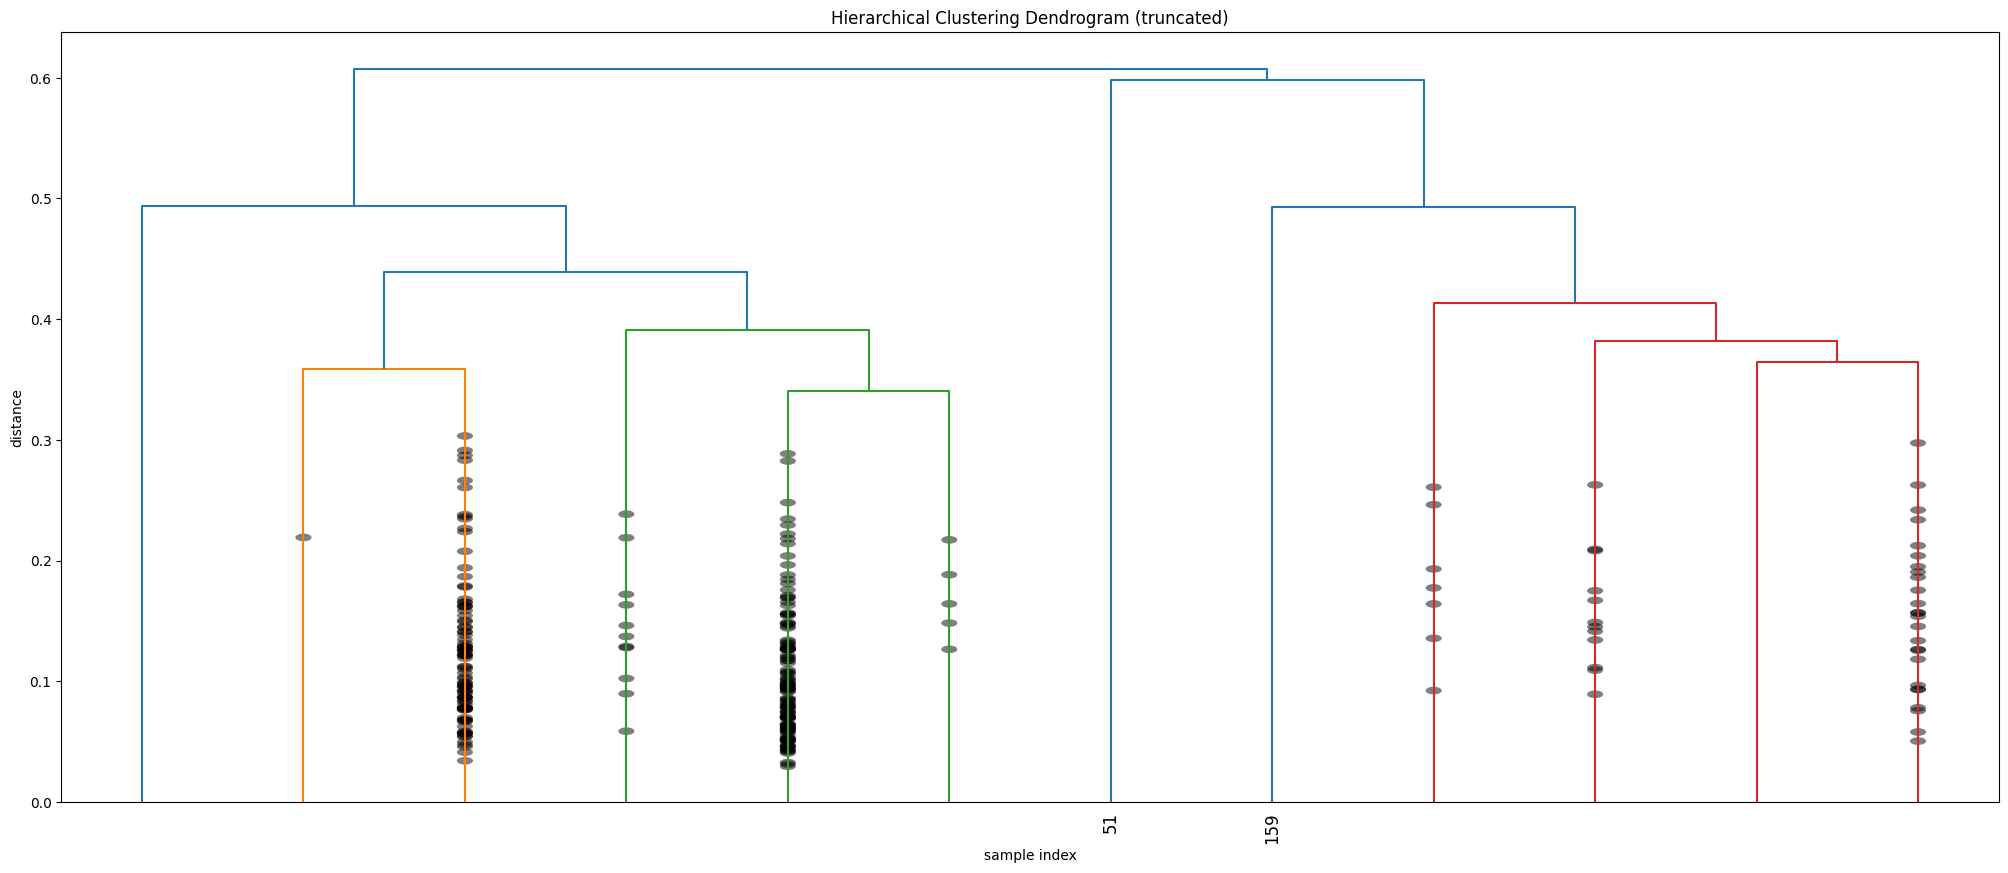

In [199]:
constructClustering()

Single Linkage tends to create long chains of clusters that follow the path of small distances. In the dendrogram, we can see that single linkage has created a long chain of clusters that goes from the top to the bottom of the graph. The set of distance values at which cluster merge occurs ranges from 0.019 to 0.564. The first merge occurs at a distance of 0.019 between datapoints 1 and 3. The last merge occurs at a distance of 0.564 between clusters 4 and 5. There are a total of 4 merges in this method. We can see that the merges in this method tend to happen at smaller distance values, which suggests that this method tends to form elongated, chain-like clusters.

Complete Linkage clustering tends to form clusters that are more compact and spherical. In the dendrogram, we can see that complete linkage has formed more compact clusters than single linkage. The set of distance values at which cluster merge occurs ranges from 0.564 to 1.414. The first merge occurs at a distance of 0.564 between clusters 4 and 5. The last merge occurs at a distance of 1.414 between clusters 2 and 6. There are a total of 5 merges in this method. We can see that the merges in this method tend to happen at larger distance values, which suggests that this method tends to form compact, spherical clusters.

Group average clustering is a compromise between single linkage and complete linkage, as it tries to form clusters that are both compact and follow the path of small distances. In the dendrogram, we can see that group average clustering has formed clusters that are somewhat compact but also follow the path of small distances. The set of distance values at which cluster merge occurs ranges from 0.038 to 0.931. The first merge occurs at a distance of 0.038 between datapoints 1 and 3. The last merge occurs at a distance of 0.931 between clusters 4 and 5. There are a total of 4 merges in this method. We can see that the merges in this method tend to happen at a wide range of distance values, which suggests that this method can form clusters of varying shapes and sizes.

# Different Clustering Solutions

In [205]:
extractClustering(3)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
[3 2 3 3 3 2 3 2 2 3 3 2 3 3 3 2 3 2 2 2 2 3 3 2 2 3 2 3 2 3 3 3 2 2 3 2 2
 2 3 3 2 2 3 3 3 3 3 2 2 2 3 1 3 2 2 3 2 2 2 2 1 1 3 3 1 1 3 1 3 3 3 1 1 3
 1 1 3 3 3 1 3 1 1 1 3 3 3 3 1 3 1 3 1 1 1 1 3 1 1 1 3 3 3 3 1 3 3 3 1 3 3
 1 3 1 3 3 3 1 3 3 3 3 1 1 3 3 3 3 1 3 1 1 1 1 1 1 1 3 3 1 1 3 3 3 1 3 3 3
 3 1 3 3 3 1 1 3 3 1 3 1 3 3 1 3 3 3 3 1 1 3 1 1 1 1 1 1 3 1 1 3 1 1 3 3 3
 1 3 3 3 1 1 1 3 1 

In [206]:
constructKmeans(3)

[2 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 2 0 0 2 2 2 2 2 0 0 1
 0 0 2 2 1 0 2 0 0 0 2 1 1 2 0 2 0 2 0 0 0 0 2 0 2 2 2 0 2 2 0 2 2 2 0 2 2
 0 2 0 1 2 1 0 2 2 2 2 2 0 2 1 2 2 0 2 0 0 0 0 0 2 0 2 2 0 0 2 2 2 2 1 2 2
 1 2 0 1 2 2 0 2 1 0 2 0 1 2 2 2 2 2 2 2 2 0 2 0 0 0 0 0 2 0 0 2 0 0 2 2 2
 2 2 2 2 0 0 2 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 1 1 2 2 0 2 2 2 1 1 2 1 1 1
 1 2 2 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 2 2 1 1 1 2 1 2 1 1 2 1 1 1 1 1 1
 1 1 1 1 2 1 2 1 1 1 2 1 1 1 2 2 1 2 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1
 1 1]


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


# Compare All Model

In [ ]:
compareModel()

I have trained and tested three different classification models: RandomForestClassifier, DecisionTreeClassifier, and GaussianNB.

RandomForestClassifier had the highest accuracy of 0.882 on the test set and also the lowest loss value of 0.32332. The confusion matrix showed that there were 12 true positive predictions for the first class, 27 true positive predictions for the second class, and 43 true positive predictions for the third class.

DecisionTreeClassifier had an accuracy of 0.860 on the test set and a loss value of 5.03836. The confusion matrix showed that there were 10 true positive predictions for the first class, 26 true positive predictions for the second class, and 44 true positive predictions for the third class.

The GaussianNB classifier achieved an accuracy score of 0.86, which is the same as the DecisionTreeClassifier. However, it had a higher log loss value of 0.51885 compared to the RandomForestClassifier. The confusion matrix showed that there were 13 true positive predictions for the first class, 23 true positive predictions for the second class, and 44 true positive predictions for the third class. This indicates that the model's predicted probabilities were less accurate and farther from the actual probabilities than those of the RandomForestClassifier.

Based on the evaluation metrics used, the RandomForestClassifier performed the best among the three models, achieving both high accuracy and low log loss values. The DecisionTreeClassifier achieved a lower accuracy score and much higher log loss value, indicating possible overfitting. The GaussianNB classifier achieved the same accuracy score as the DecisionTreeClassifier, but had a higher log loss value, indicating less accurate probability predictions.